In [2]:
import pandas as pd
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt
import seaborn as sns

读取数据

In [3]:
stock = pd.read_csv("stock_hs300.csv")
stock = stock.iloc[:,[1,2,3,4,5,6]]
stock.rename(columns={"名称":"name","日期":"date","开盘价(元)":"open","最高价(元)":"high","最低价(元)":"low","收盘价(元)":"close"},inplace=True)


In [3]:
# stock = pd.read_csv("sz50.csv")
# stock = stock.iloc[:,[1,2,3,4,5,6]]
# stock.rename(columns={"名称":"name","日期":"date","开盘价(元)":"open","最高价(元)":"high","最低价(元)":"low","收盘价(元)":"close"},inplace=True)

In [10]:
# stock = pd.read_csv("windA.csv")
# stock = stock.iloc[:,[1,2,3,4,5,6]]
# stock.rename(columns={"名称":"name","日期":"date","开盘价(元)":"open","最高价(元)":"high","最低价(元)":"low","收盘价(元)":"close"},inplace=True)

In [4]:
stock["date"] = pd.to_datetime(stock["date"])
stock.set_index('date',inplace=False)

,name,open,high,low,close
date,,,,,
2005-01-04,沪深300,994.77,994.77,980.66,982.79
2005-01-05,沪深300,981.58,997.32,979.88,992.56
2005-01-06,沪深300,993.33,993.79,980.33,983.17
2005-01-07,沪深300,983.05,995.71,979.81,983.96
2005-01-10,沪深300,983.76,993.96,979.79,993.88
...,...,...,...,...,...
2022-03-31,沪深300,4234.72,4247.36,4214.54,4222.60
2022-04-01,沪深300,4198.82,4290.67,4190.08,4276.16
2022-04-06,沪深300,4258.83,4277.52,4236.73,4263.84


循环回测，优化N,M和信号阈值的取值。阈值取0.5-1，步长为0.5；N取10-21，步长为2；M取500-1000，步长为100

In [5]:
# 计算信号阈值 (norm,modfy,right) 返回阈值，总收益率，最大回撤
def Calthreshold(data,method,N,M):
    stock = data.copy()
    result = []
    for sign in range(50,100,5):
        sign = sign/100
        cost = 0.0001
        money = 1000000
        position = 0
        num = 0
        record = []
        for index,row in stock.iterrows():
            if method == "norm": # 如果用标准分
                if row['beta_norm']>sign and position ==0:
                    position = 1
                    # buytime = row["date"]
                    buyprice = row['close']
                    num = (money//row['close']//100)*100
                    money = money-num*row['close']*(1+cost)
                if row['beta_norm']<-sign and position ==1:
                    position = 0
                    # selltime = row["date"]
                    money = money + num*row['close']*(1-cost)
                if row['close'] < buyprice*0.8 and position ==1: #止损
                    position = 0
                    # selltime = row["date"]
                    money = money + num*row['close']*(1-cost)
                if index == len(data)-1 and position==1:
                    position = 0
                    # selltime = row["date"]
                    money = money + num*row['close']*(1-cost)
                if position ==1:
                    money_daily = money+num*row["close"]
                    record.append(money_daily)
                elif position == 0:
                    money_daily = money
                    record.append(money_daily)
            if method == "modfy": # 如果用标准分
                if row['beta_modfy']>sign and position ==0:
                    position = 1
                    # buytime = row["date"]
                    buyprice = row['close']
                    num = (money//row['close']//100)*100
                    money = money-num*row['close']*(1+cost)
                if row['beta_modfy']<-sign and position ==1:
                    position = 0
                    # selltime = row["date"]
                    money = money + num*row['close']*(1-cost)
                if row['close'] < buyprice*0.8 and position ==1: #止损
                    position = 0
                    # selltime = row["date"]
                    money = money + num*row['close']*(1-cost)
                if index == len(data)-1 and position==1:
                    position = 0
                    # selltime = row["date"]
                    money = money + num*row['close']*(1-cost)
                if position ==1:
                    money_daily = money+num*row["close"]
                    record.append(money_daily)
                elif position == 0:
                    money_daily = money
                    record.append(money_daily)
            if method == "right": # 如果用标准分
                if row['beta_right']>sign and position ==0:
                    position = 1
                    # buytime = row["date"]
                    buyprice = row['close']
                    num = (money//row['close']//100)*100
                    money = money-num*row['close']*(1+cost)
                if row['beta_right']<-sign and position ==1:
                    position = 0
                    # selltime = row["date"]
                    money = money + num*row['close']*(1-cost)
                if row['close'] < buyprice*0.8 and position ==1: #止损
                    position = 0
                    # selltime = row["date"]
                    money = money + num*row['close']*(1-cost)
                if index == len(data)-1 and position==1:
                    position = 0
                    # selltime = row["date"]
                    money = money + num*row['close']*(1-cost)
                if position ==1:
                    money_daily = money+num*row["close"]
                elif position == 0:
                    money_daily = money
                record.append(money_daily)
        record = pd.DataFrame(record,columns=["money"])
        drawdown=((record["money"].cummax()-record["money"])/record["money"].cummax()).max() #最大回撤
        result.append([N,M,method,sign,record['money'].values[-1]/1000000 - 1,drawdown])
    result = pd.DataFrame(result,columns=["N","M","method","threshold","rtn","drawdown"])    
    return result
            

In [6]:
result_norm_ = pd.DataFrame(columns=["N","M","method","threshold","rtn","drawdown"])
result_modfy_ = pd.DataFrame(columns=["N","M","method","threshold","rtn","drawdown"])
result_right_ = pd.DataFrame(columns=["N","M","method","threshold","rtn","drawdown"])

In [7]:
#计算回归方程的斜率和R2
# 向前选取N计算斜率和R2
for N in range(10,21,2):
    data = stock.copy()
    data['beta'] = 0
    data['R2'] = 0
    for i in range(N-1,len(data)):
        df_beta = data.loc[i-N+1:i,:] 
        X = np.array(df_beta['low']).reshape(-1,1)
        Y = np.array(df_beta['high']).reshape(-1,1)
        clf = linear_model.LinearRegression()
        clf.fit(X,Y)
        data['beta'][i+1] = clf.coef_
        data['R2'][i+1] = clf.score(X,Y)
    for M in range(500,1001,100):
     # 向前选取600计算标准分
        data_ = data.copy()
        data_['ret'] = 0
        data_["beta_norm"] =0
        data_['beta_modfy'] = 0
        data_['beta_right'] = 0
        # 日收益率
        data_['ret'] = data_["close"].pct_change(1)
        # 标准分
        data_["beta_norm"] = (data_['beta']- data_['beta'].rolling(M).mean().shift(1))/data_['beta'].rolling(M).std().shift(1)
        # 去除空缺
        data_ = data_.dropna(how="any",axis=0,inplace=False)
        # 修正标准分
        data_['beta_modfy']  = data_["beta_norm"]*data_['R2']
        # 右偏标准分
        data_['beta_right'] = data_["beta_modfy"]*data_['beta']
        data_ = data_.reset_index(drop=True)
        # print(N,M,data_.head(10))
        data_["date"] = pd.to_datetime(data_["date"])
        data_ = data_.set_index("date",inplace=False)
        data_ = data_['2009':]
        result_norm = Calthreshold(data_,"norm",N,M)
        result_modfy = Calthreshold(data_,"modfy",N,M)
        result_right = Calthreshold(data_,"right",N,M)
        result_norm_ = pd.concat([result_norm_,result_norm],ignore_index=True)
        result_modfy_ = pd.concat([result_modfy_,result_modfy],ignore_index=True)
        result_right_ = pd.concat([result_right_,result_right],ignore_index=True)

C:\Users\HYJ\AppData\Local\Temp\ipykernel_7924\2488794658.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['beta'][i+1] = clf.coef_
C:\Users\HYJ\AppData\Local\Temp\ipykernel_7924\2488794658.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['R2'][i+1] = clf.score(X,Y)
C:\Users\HYJ\AppData\Local\Temp\ipykernel_7924\2488794658.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['beta'][i+1] = clf.coef_
C:\Users\HYJ\

In [8]:
result_norm_ = result_norm_.sort_values(by = "rtn",ascending=False) # 按rtn降序排列
result_norm_

,N,M,method,threshold,rtn,drawdown
219,16,800,norm,0.95,4.641253,0.226402
229,16,900,norm,0.95,4.441752,0.235144
287,18,900,norm,0.85,4.313763,0.214656
228,16,900,norm,0.9,4.291004,0.222378
279,18,800,norm,0.95,4.264039,0.23406
...,...,...,...,...,...,...
232,16,1000,norm,0.6,0.563103,0.269391
173,14,1000,norm,0.65,0.550293,0.235665
231,16,1000,norm,0.55,0.526602,0.27874
172,14,1000,norm,0.6,0.504568,0.303342


In [9]:
result_modfy_ = result_modfy_.sort_values(by = "rtn",ascending=False) # 按rtn降序排列
result_modfy_

,N,M,method,threshold,rtn,drawdown
228,16,900,modfy,0.9,5.400192,0.247518
4,10,500,modfy,0.7,5.296348,0.197065
287,18,900,modfy,0.85,5.256674,0.241129
276,18,800,modfy,0.8,5.210735,0.234283
278,18,800,modfy,0.9,5.198688,0.234635
...,...,...,...,...,...,...
290,18,1000,modfy,0.5,0.793532,0.215995
172,14,1000,modfy,0.6,0.645715,0.234399
170,14,1000,modfy,0.5,0.61899,0.278866
230,16,1000,modfy,0.5,0.574341,0.282898


In [10]:
result_right_ = result_right_.sort_values(by = "rtn",ascending=False) # 按rtn降序排列
result_right_

,N,M,method,threshold,rtn,drawdown
277,18,800,right,0.85,6.332907,0.270658
287,18,900,right,0.85,5.742613,0.266591
284,18,900,right,0.7,5.534487,0.241041
286,18,900,right,0.8,5.514706,0.271444
276,18,800,right,0.8,5.505959,0.268982
...,...,...,...,...,...,...
56,10,1000,right,0.8,0.648566,0.430535
94,12,800,right,0.7,0.631983,0.4864
115,12,1000,right,0.75,0.618208,0.343512
114,12,1000,right,0.7,0.572976,0.379943


所以N取18，M取800，用右偏标准分，threshold取0.85时比较合适

In [20]:
N=18
M=800
# 计算斜率和R2
data = stock.copy()
data['beta'] = 0
data['R2'] = 0
for i in range(N-1,len(data)):
    df_beta = data.loc[i-N+1:i,:] 
    X = np.array(df_beta['low']).reshape(-1,1)
    Y = np.array(df_beta['high']).reshape(-1,1)
    clf = linear_model.LinearRegression()
    clf.fit(X,Y)
    data['beta'][i+1] = clf.coef_
    data['R2'][i+1] = clf.score(X,Y)
data['ret'] = 0
data["beta_norm"] =0
data['beta_modfy'] = 0
data['beta_right'] = 0
# 日收益率
data['ret'] = data["close"].pct_change(1)
# 标准分
data["beta_norm"] = (data['beta']- data['beta'].rolling(M).mean().shift(1))/data['beta'].rolling(M).std().shift(1)
# 去除空缺
data = data.dropna(how="any",axis=0,inplace=False)
# 修正标准分
data['beta_modfy']  = data["beta_norm"]*data['R2']
# 右偏标准分
data['beta_right'] = data["beta_modfy"]*data['beta']
data = data.reset_index(drop=True)


C:\Users\HYJ\AppData\Local\Temp\ipykernel_30836\1070206668.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['beta'][i+1] = clf.coef_
C:\Users\HYJ\AppData\Local\Temp\ipykernel_30836\1070206668.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['R2'][i+1] = clf.score(X,Y)
C:\Users\HYJ\AppData\Local\Temp\ipykernel_30836\1070206668.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

In [21]:
data = data.set_index(pd.to_datetime(data["date"]))
data = data["2009":]

D:\Anaconda3\envs\fintech\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Anaconda3\envs\fintech\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Anaconda3\envs\fintech\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-

<AxesSubplot:xlabel='beta_right', ylabel='Density'>

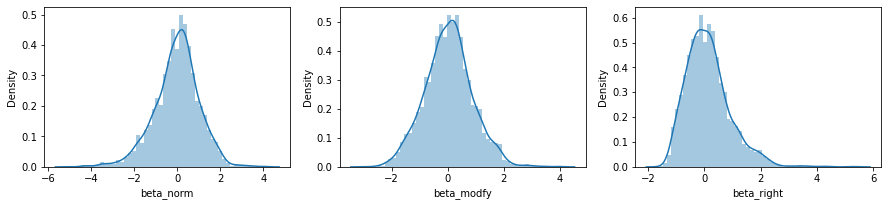

In [13]:
# 作标准分，修正标准分和右偏标准分的密度图
f = plt.figure(figsize=(15,10))
f.add_subplot(3,3,1)
sns.distplot(data["beta_norm"])
f.add_subplot(3,3,2)
sns.distplot(data["beta_modfy"])
f.add_subplot(3,3,3)
sns.distplot(data["beta_right"])
# plt.xlabel("value")
# plt.title("norm")
# plt.show()

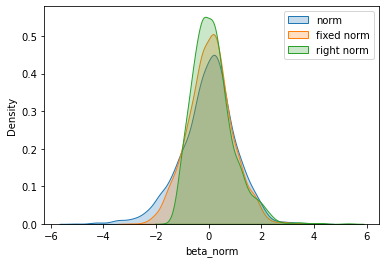

In [14]:
f,ax = plt.subplots(1, 1)
sns.kdeplot(data["beta_norm"],shade=True,label = "norm",ax=ax)
sns.kdeplot(data["beta_modfy"],shade=True,label = "fixed norm",ax=ax)
sns.kdeplot(data["beta_right"],shade=True, label = "right norm",ax=ax)
ax.legend()

策略的回测检验

In [6]:
bbindex = pd.read_csv("bbindex.csv")
bbindex = bbindex.set_index(pd.to_datetime(bbindex["date"]))
bbindex = bbindex["2009":]

In [7]:
data["bbindex"] = bbindex["bbindex"]
data = data.fillna(method="ffill")

In [12]:
data

,name,date,open,high,low,close,beta,R2,ret,beta_norm,beta_modfy,beta_right
date,,,,,,,,,,,,
2009-01-05,沪深300,2009/1/5,1848.33,1882.96,1837.84,1882.96,1.093316,0.953316,0.035891,1.587270,1.513170,1.654372
2009-01-06,沪深300,2009/1/6,1880.67,1948.49,1873.01,1942.80,1.103207,0.953769,0.031780,1.673418,1.596054,1.760777
2009-01-07,沪深300,2009/1/7,1942.67,1959.25,1930.87,1931.18,1.093884,0.944915,-0.005981,1.582542,1.495367,1.635759
2009-01-08,沪深300,2009/1/8,1894.66,1902.80,1873.65,1887.99,1.072625,0.932465,-0.022365,1.382922,1.289526,1.383178
2009-01-09,沪深300,2009/1/9,1886.49,1923.42,1886.49,1918.37,1.084286,0.915672,0.016091,1.485938,1.360631,1.475314
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-31,沪深300,2022/3/31,4234.72,4247.36,4214.54,4222.60,0.617281,0.662496,-0.007405,-2.516639,-1.667263,-1.029170
2022-04-01,沪深300,2022/4/1,4198.82,4290.67,4190.08,4276.16,0.499977,0.577634,0.012684,-3.515624,-2.030744,-1.015325
2022-04-06,沪深300,2022/4/6,4258.83,4277.52,4236.73,4263.84,0.453671,0.579616,-0.002881,-3.880998,-2.249488,-1.020529


In [22]:
data = data.copy()
threshold = 0.85 # 阈值
cost = 0.0001 #交易手续费
money = 1000000 # 仓位限制
position = 0 # 仓位信号
num = 0 # 交易股数
record = [] # 记录交易信息
record_daily = []
for index,row in data.iterrows():    
    if row['beta_right']>threshold and position ==0 : # 仓位为空，大于阈值，买入
        position = 1
        buytime = row["date"]
        buyprice = row['close']
        num = (money//row['close']//100)*100 # 股数只能为100整数倍
        money = money-num*row['close']*(1+cost)      
    elif row['beta_right']<-threshold and position ==1: # 仓位为满，小于阈值，卖出
        position = 0
        selltime = row["date"]
        money = money + num*row['close']*(1-cost)
        record.append([buytime,selltime,num,money]) 
    elif row['close'] < buyprice*0.8 and position ==1: #止损
        position = 0
        selltime = row["date"]
        money = money + num*row['close']*(1-cost)
        record.append([buytime,selltime,num,money]) 
    elif index == len(data)-1 and position ==1: # 仓位为满，回测到最后一天，卖出
        position = 0
        selltime = row["date"]
        money = money + num*row['close']*(1-cost)
        record.append([buytime,selltime,num,money]) 
    
    if position ==1 :
        money_daily = money+row['close']*num
    elif position == 0:
        money_daily = money
    record_daily.append([row["date"],money_daily,position])

        

record = pd.DataFrame(record,columns=["buytime","selltime","num","money"])
record_daily = pd.DataFrame(record_daily,columns=["date","money","position"])


In [23]:
record["rtn"] = record["money"].pct_change()
stock_rtn = record_daily['money'].pct_change() # 策略每日收益率
hs300_rtn = data["close"].pct_change() # 基准每日收益率（hs300）
excess_rtn = stock_rtn.values - hs300_rtn.values # 每日超额收益率
avg_excess_return = np.nanmean(excess_rtn) # 每日超额收益率的均值
sd_excess_return = np.nanstd(excess_rtn) # 每日超额收益率的标准差
sharpe_ratio = (avg_excess_return/sd_excess_return)*np.sqrt(252) # 夏普比率



In [24]:
peryear_rtn = (record_daily['money'].values[-1]/1000000)**(1/(len(record_daily['money'])/365))-1# 年化收益率
peryear_rtn_benchmark = ((data["close"].values[-1]/data["close"].values[1])**(1/(len(data["close"])/365))-1) # 基准年化收益率
accumulated_rtn = record_daily['money'].values[-1]/1000000 -1 # 累计收益率
benchmark_rtn = data["close"][-1]/data["close"][1] - 1 #基准收益率
alpha = peryear_rtn - peryear_rtn_benchmark # alpha
beta = np.cov(stock_rtn.dropna(),hs300_rtn.dropna())[0][1]/np.var(hs300_rtn.dropna()) #beta
rtn_per_trade = record["money"].pct_change(1).mean() #每笔收益率
number_of_trades = len(record) #交易笔数
hold_days = len(record_daily[record_daily["position"]==1]) #持仓时间
win_days = len(record_daily[record_daily["money"].pct_change()>0])#盈利天数
loss_days = len(record_daily[record_daily["money"].pct_change()<0])#亏损天数
win_rate = (record["money"].pct_change(1)>0).value_counts()[1]/len(record) #胜率
win_ratio = record[record["rtn"]>0]["rtn"].mean()# 盈利率（按每笔交易）
loss_ratio = -record[record["rtn"]<0]["rtn"].mean()# 亏损率（按每笔交易）
win_loss = win_ratio/loss_ratio # 盈亏比（按每笔交易）
vol = np.nanstd(stock_rtn)*np.sqrt(252)
drawdown=((record_daily["money"].cummax()-record_daily["money"])/record_daily["money"].cummax()).max() #最大回撤
information_ratio = (peryear_rtn-peryear_rtn_benchmark)/sd_excess_return # 信息比率
result = pd.DataFrame([[peryear_rtn,peryear_rtn_benchmark,accumulated_rtn,benchmark_rtn,rtn_per_trade,alpha,beta,number_of_trades,win_rate,hold_days,win_days,loss_days,win_ratio,loss_ratio,win_loss,vol,drawdown,sharpe_ratio,information_ratio]],columns=["年化收益率","基准年化收益率","累计收益率","基准收益率","每笔收益率","alpha","beta","交易次数","胜率","持仓天数","盈利天数","亏损天数","盈利率（按每笔交易）","亏损率（按每笔交易）","盈亏比（按每笔交易）","波动率","最大回撤","夏普比率","信息比率"])
result

,年化收益率,基准年化收益率,累计收益率,基准收益率,每笔收益率,alpha,beta,交易次数,胜率,持仓天数,盈利天数,亏损天数,盈利率（按每笔交易）,亏损率（按每笔交易）,盈亏比（按每笔交易）,波动率,最大回撤,夏普比率,信息比率
0,0.253116,0.092137,6.332907,1.177666,0.05813,0.160979,0.468083,32,0.65625,1867,1005,893,0.100876,0.031636,3.188598,0.158966,0.270658,0.453638,15.043317


In [16]:
record_1 = record_daily.iloc[:,:2]
record_1["hs300"] = (data["close"].values)*(1000000/data["close"][0])
record_1 = record_1.rename(columns={"money":"斜率"})

In [17]:
record_1.to_csv("beta_benchmark.csv")

In [231]:
# record_hs300 = record_daily.iloc[:,:2]
# record_hs300 = record_hs300.rename(columns={"money":"hs300"})

In [239]:

# record_sz50 = pd.concat([record_hs300,record_daily["money"]],axis=1)
# record_sz50 = record_sz50.rename(columns={"money":"sz50"})

In [248]:

# record_winda = pd.concat([record_sz50,record_daily["money"]],axis=1)
# record_winda = record_winda.rename(columns={"money":"windA"})

In [250]:
# record_winda.to_excel("hs300_sz50_winda.xlsx")

加入牛熊指标

In [129]:
data["bbnindex_20"] = data["bbindex"].rolling(5).mean()
data["bbnindex_20"] = data["bbnindex_20"].fillna(method="bfill") # 牛熊指标的20日均线

In [130]:
data["bbnindex_20_3"] = data["bbnindex_20"].shift(3)
data["bbnindex_20_3"] = data["bbnindex_20_3"].fillna(method="bfill") # 3天前牛熊指标的20日均线

In [13]:
data["bbindex_10"] = data["bbindex"].shift(10)
data["bbindex_10"] = data["bbindex_10"].fillna(method="bfill") # 3天前牛熊指标的20日均线

In [14]:
data = data.copy()
threshold = 0.85 # 阈值
cost = 0.0001 #交易手续费
money = 1000000 # 仓位限制
position = 0 # 仓位信号
num = 0 # 交易股数
record = [] # 记录交易信息
record_daily = []
for index,row in data.iterrows():    
    if row['beta_right']>threshold and position ==0 and row["bbindex"]<row["bbindex_10"]: # 仓位为空，大于阈值，买入
        position = 1
        buytime = row["date"]
        buyprice = row['close']
        num = (money//row['close']//100)*100 # 股数只能为100整数倍
        money = money-num*row['close']*(1+cost)      
    elif row['beta_right']<-threshold and position ==1 and row["bbindex"]>row["bbindex_10"]: # 仓位为满，小于阈值，卖出
        position = 0
        selltime = row["date"]
        money = money + num*row['close']*(1-cost)
        record.append([buytime,selltime,num,money]) 
    elif row['close'] < buyprice*0.8 and position ==1: #止损
        position = 0
        selltime = row["date"]
        money = money + num*row['close']*(1-cost)
        record.append([buytime,selltime,num,money]) 
    elif index == len(data)-1 and position ==1: # 仓位为满，回测到最后一天，卖出
        position = 0
        selltime = row["date"]
        money = money + num*row['close']*(1-cost)
        record.append([buytime,selltime,num,money]) 
    
    if position ==1 :
        money_daily = money+row['close']*num
    elif position == 0:
        money_daily = money
    record_daily.append([row["date"],money_daily,position])

        

record = pd.DataFrame(record,columns=["buytime","selltime","num","money"])
record_daily = pd.DataFrame(record_daily,columns=["date","money","position"])

In [15]:
record["rtn"] = record["money"].pct_change()
stock_rtn = record_daily['money'].pct_change() # 策略每日收益率
hs300_rtn = data["close"].pct_change() # 基准每日收益率（hs300）
excess_rtn = stock_rtn.values - hs300_rtn.values # 每日超额收益率
avg_excess_return = np.nanmean(excess_rtn) # 每日超额收益率的均值
sd_excess_return = np.nanstd(excess_rtn) # 每日超额收益率的标准差
sharpe_ratio = (avg_excess_return/sd_excess_return)*np.sqrt(252) # 夏普比率
peryear_rtn = (record_daily['money'].values[-1]/1000000)**(1/(len(record_daily['money'])/365))-1# 年化收益率
peryear_rtn_benchmark = ((data["close"].values[-1]/data["close"].values[1])**(1/(len(data["close"])/365))-1) # 基准年化收益率
accumulated_rtn = record_daily['money'].values[-1]/1000000 -1 # 累计收益率
benchmark_rtn = data["close"][-1]/data["close"][1] - 1 #基准收益率
alpha = peryear_rtn - peryear_rtn_benchmark # alpha
beta = np.cov(stock_rtn.dropna(),hs300_rtn.dropna())[0][1]/np.var(hs300_rtn.dropna()) #beta
rtn_per_trade = record["money"].pct_change(1).mean() #每笔收益率
number_of_trades = len(record) #交易笔数
hold_days = len(record_daily[record_daily["position"]==1]) #持仓时间
win_days = len(record_daily[record_daily["money"].pct_change()>0])#盈利天数
loss_days = len(record_daily[record_daily["money"].pct_change()<0])#亏损天数
win_rate = (record["money"].pct_change(1)>0).value_counts()[1]/len(record) #胜率
win_ratio = record[record["rtn"]>0]["rtn"].mean()# 盈利率（按每笔交易）
loss_ratio = -record[record["rtn"]<0]["rtn"].mean()# 亏损率（按每笔交易）
win_loss = win_ratio/loss_ratio # 盈亏比（按每笔交易）
vol = np.nanstd(stock_rtn)*np.sqrt(252)
drawdown=((record_daily["money"].cummax()-record_daily["money"])/record_daily["money"].cummax()).max() #最大回撤
information_ratio = (peryear_rtn-peryear_rtn_benchmark)/sd_excess_return # 信息比率
result = pd.DataFrame([[peryear_rtn,peryear_rtn_benchmark,accumulated_rtn,benchmark_rtn,rtn_per_trade,alpha,beta,number_of_trades,win_rate,hold_days,win_days,loss_days,win_ratio,loss_ratio,win_loss,vol,drawdown,sharpe_ratio,information_ratio]],columns=["年化收益率","基准年化收益率","累计收益率","基准收益率","每笔收益率","alpha","beta","交易次数","胜率","持仓天数","盈利天数","亏损天数","盈利率（按每笔交易）","亏损率（按每笔交易）","盈亏比（按每笔交易）","波动率","最大回撤","夏普比率","信息比率"])
result

,年化收益率,基准年化收益率,累计收益率,基准收益率,每笔收益率,alpha,beta,交易次数,胜率,持仓天数,盈利天数,亏损天数,盈利率（按每笔交易）,亏损率（按每笔交易）,盈亏比（按每笔交易）,波动率,最大回撤,夏普比率,信息比率
0,0.178695,0.092137,3.270565,1.177666,0.101887,0.086558,0.49888,14,0.642857,1993,1088,919,0.16371,0.037217,4.398842,0.161984,0.256898,0.217254,8.459809


In [16]:
record_1 = pd.concat([record_1,record_daily["money"]],axis=1)
record_1 = record_1.rename(columns={"money":"rsrs+niuxiong"})

加入均线策略

In [17]:
data["ma20"] = data["close"].rolling(20).mean()
data["ma20"] = data["ma20"].fillna(method="bfill") # 牛熊指标的20日均线
data["ma20_10"] = data["ma20"].shift(10)
data["ma20_10"] = data["ma20_10"].fillna(method="bfill") # 3天前牛熊指标的20日均线

In [19]:
data = data.copy()
threshold = 0.85 # 阈值
cost = 0.0001 #交易手续费
money = 1000000 # 仓位限制
position = 0 # 仓位信号
num = 0 # 交易股数
record = [] # 记录交易信息
record_daily = []
for index,row in data.iterrows():    
    if row['beta_right']>threshold and position ==0 and row["ma20"]>row["ma20_10"]: # 仓位为空，大于阈值，买入
        position = 1
        buytime = row["date"]
        buyprice = row['close']
        num = (money//row['close']//100)*100 # 股数只能为100整数倍
        money = money-num*row['close']*(1+cost)      
    elif row['beta_right']<-threshold and position ==1 and row["ma20"]<row["ma20_10"]: # 仓位为满，小于阈值，卖出
        position = 0
        selltime = row["date"]
        money = money + num*row['close']*(1-cost)
        record.append([buytime,selltime,num,money]) 
    elif row['close'] < buyprice*0.8 and position ==1: #止损
        position = 0
        selltime = row["date"]
        money = money + num*row['close']*(1-cost)
        record.append([buytime,selltime,num,money]) 
    elif index == len(data)-1 and position ==1: # 仓位为满，回测到最后一天，卖出
        position = 0
        selltime = row["date"]
        money = money + num*row['close']*(1-cost)
        record.append([buytime,selltime,num,money]) 
    
    if position ==1 :
        money_daily = money+row['close']*num
    elif position == 0:
        money_daily = money
    record_daily.append([row["date"],money_daily,position])

        

record = pd.DataFrame(record,columns=["buytime","selltime","num","money"])
record_daily = pd.DataFrame(record_daily,columns=["date","money","position"])

In [20]:
record["rtn"] = record["money"].pct_change()
stock_rtn = record_daily['money'].pct_change() # 策略每日收益率
hs300_rtn = data["close"].pct_change() # 基准每日收益率（hs300）
excess_rtn = stock_rtn.values - hs300_rtn.values # 每日超额收益率
avg_excess_return = np.nanmean(excess_rtn) # 每日超额收益率的均值
sd_excess_return = np.nanstd(excess_rtn) # 每日超额收益率的标准差
sharpe_ratio = (avg_excess_return/sd_excess_return)*np.sqrt(252) # 夏普比率
peryear_rtn = (record_daily['money'].values[-1]/1000000)**(1/(len(record_daily['money'])/365))-1# 年化收益率
peryear_rtn_benchmark = ((data["close"].values[-1]/data["close"].values[1])**(1/(len(data["close"])/365))-1) # 基准年化收益率
accumulated_rtn = record_daily['money'].values[-1]/1000000 -1 # 累计收益率
benchmark_rtn = data["close"][-1]/data["close"][1] - 1 #基准收益率
alpha = peryear_rtn - peryear_rtn_benchmark # alpha
beta = np.cov(stock_rtn.dropna(),hs300_rtn.dropna())[0][1]/np.var(hs300_rtn.dropna()) #beta
rtn_per_trade = record["money"].pct_change(1).mean() #每笔收益率
number_of_trades = len(record) #交易笔数
hold_days = len(record_daily[record_daily["position"]==1]) #持仓时间
win_days = len(record_daily[record_daily["money"].pct_change()>0])#盈利天数
loss_days = len(record_daily[record_daily["money"].pct_change()<0])#亏损天数
win_rate = (record["money"].pct_change(1)>0).value_counts()[1]/len(record) #胜率
win_ratio = record[record["rtn"]>0]["rtn"].mean()# 盈利率（按每笔交易）
loss_ratio = -record[record["rtn"]<0]["rtn"].mean()# 亏损率（按每笔交易）
win_loss = win_ratio/loss_ratio # 盈亏比（按每笔交易）
vol = np.nanstd(stock_rtn)*np.sqrt(252)
drawdown=((record_daily["money"].cummax()-record_daily["money"])/record_daily["money"].cummax()).max() #最大回撤
information_ratio = (peryear_rtn-peryear_rtn_benchmark)/sd_excess_return # 信息比率
result = pd.DataFrame([[peryear_rtn,peryear_rtn_benchmark,accumulated_rtn,benchmark_rtn,rtn_per_trade,alpha,beta,number_of_trades,win_rate,hold_days,win_days,loss_days,win_ratio,loss_ratio,win_loss,vol,drawdown,sharpe_ratio,information_ratio]],columns=["年化收益率","基准年化收益率","累计收益率","基准收益率","每笔收益率","alpha","beta","交易次数","胜率","持仓天数","盈利天数","亏损天数","盈利率（按每笔交易）","亏损率（按每笔交易）","盈亏比（按每笔交易）","波动率","最大回撤","夏普比率","信息比率"])
result

,年化收益率,基准年化收益率,累计收益率,基准收益率,每笔收益率,alpha,beta,交易次数,胜率,持仓天数,盈利天数,亏损天数,盈利率（按每笔交易）,亏损率（按每笔交易）,盈亏比（按每笔交易）,波动率,最大回撤,夏普比率,信息比率
0,0.142462,0.092137,2.241524,1.177666,0.090443,0.050325,0.536657,13,0.615385,1975,1077,911,0.175863,0.080397,2.18743,0.168193,0.247106,0.094907,5.134726


In [21]:
record_1 = pd.concat([record_1,record_daily["money"]],axis=1)
record_1 = record_1.rename(columns={"money":"rsrs+ma"})

In [23]:
record_1.to_excel("record_hs300.xlsx")

交易量优化

In [31]:
turnover = pd.read_csv("correlation coefficient of beta.csv")
turnover = turnover.iloc[:,[0,3,6]]

In [32]:
data["tr_right"] = turnover["tr_right"].values
data["bb_right"] = turnover["bb_right"].values

In [52]:
data = data.copy()
threshold = 0.85 # 阈值
cost = 0.0001 #交易手续费
money = 1000000 # 仓位限制
position = 0 # 仓位信号
num = 0 # 交易股数
record = [] # 记录交易信息
record_daily = []
for index,row in data.iterrows():    
    if row['beta_right']>threshold and position ==0 and row["bb_right"]>0: # 仓位为空，大于阈值，买入
        position = 1
        buytime = row["date"]
        buyprice = row['close']
        num = (money//row['close']//100)*100 # 股数只能为100整数倍
        money = money-num*row['close']*(1+cost)      
    elif row['beta_right']<-threshold and position ==1 and row["bb_right"]<0: # 仓位为满，小于阈值，卖出
        position = 0
        selltime = row["date"]
        money = money + num*row['close']*(1-cost)
        record.append([buytime,selltime,num,money]) 
    elif row['close'] < buyprice*0.8 and position ==1: #止损
        position = 0
        selltime = row["date"]
        money = money + num*row['close']*(1-cost)
        record.append([buytime,selltime,num,money]) 
    elif index == len(data)-1 and position ==1: # 仓位为满，回测到最后一天，卖出
        position = 0
        selltime = row["date"]
        money = money + num*row['close']*(1-cost)
        record.append([buytime,selltime,num,money]) 
    
    if position ==1 :
        money_daily = money+row['close']*num
    elif position == 0:
        money_daily = money
    record_daily.append([row["date"],money_daily,position])

        

record = pd.DataFrame(record,columns=["buytime","selltime","num","money"])
record_daily = pd.DataFrame(record_daily,columns=["date","money","position"])

In [53]:
record["rtn"] = record["money"].pct_change()
stock_rtn = record_daily['money'].pct_change() # 策略每日收益率
hs300_rtn = data["close"].pct_change() # 基准每日收益率（hs300）
excess_rtn = stock_rtn.values - hs300_rtn.values # 每日超额收益率
avg_excess_return = np.nanmean(excess_rtn) # 每日超额收益率的均值
sd_excess_return = np.nanstd(excess_rtn) # 每日超额收益率的标准差
sharpe_ratio = (avg_excess_return/sd_excess_return)*np.sqrt(252) # 夏普比率
peryear_rtn = (record_daily['money'].values[-1]/1000000)**(1/(len(record_daily['money'])/365))-1# 年化收益率
peryear_rtn_benchmark = ((data["close"].values[-1]/data["close"].values[1])**(1/(len(data["close"])/365))-1) # 基准年化收益率
accumulated_rtn = record_daily['money'].values[-1]/1000000 -1 # 累计收益率
benchmark_rtn = data["close"][-1]/data["close"][1] - 1 #基准收益率
alpha = peryear_rtn - peryear_rtn_benchmark # alpha
beta = np.cov(stock_rtn.dropna(),hs300_rtn.dropna())[0][1]/np.var(hs300_rtn.dropna()) #beta
rtn_per_trade = record["money"].pct_change(1).mean() #每笔收益率
number_of_trades = len(record) #交易笔数
hold_days = len(record_daily[record_daily["position"]==1]) #持仓时间
win_days = len(record_daily[record_daily["money"].pct_change()>0])#盈利天数
loss_days = len(record_daily[record_daily["money"].pct_change()<0])#亏损天数
win_rate = (record["money"].pct_change(1)>0).value_counts()[1]/len(record) #胜率
win_ratio = record[record["rtn"]>0]["rtn"].mean()# 盈利率（按每笔交易）
loss_ratio = -record[record["rtn"]<0]["rtn"].mean()# 亏损率（按每笔交易）
win_loss = win_ratio/loss_ratio # 盈亏比（按每笔交易）
vol = np.nanstd(stock_rtn)*np.sqrt(252)
drawdown=((record_daily["money"].cummax()-record_daily["money"])/record_daily["money"].cummax()).max() #最大回撤
information_ratio = (peryear_rtn-peryear_rtn_benchmark)/sd_excess_return # 信息比率
result = pd.DataFrame([[peryear_rtn,peryear_rtn_benchmark,accumulated_rtn,benchmark_rtn,rtn_per_trade,alpha,beta,number_of_trades,win_rate,hold_days,win_days,loss_days,win_ratio,loss_ratio,win_loss,vol,drawdown,sharpe_ratio,information_ratio]],columns=["年化收益率","基准年化收益率","累计收益率","基准收益率","每笔收益率","alpha","beta","交易次数","胜率","持仓天数","盈利天数","亏损天数","盈利率（按每笔交易）","亏损率（按每笔交易）","盈亏比（按每笔交易）","波动率","最大回撤","夏普比率","信息比率"])
result

,年化收益率,基准年化收益率,累计收益率,基准收益率,每笔收益率,alpha,beta,交易次数,胜率,持仓天数,盈利天数,亏损天数,盈利率（按每笔交易）,亏损率（按每笔交易）,盈亏比（按每笔交易）,波动率,最大回撤,夏普比率,信息比率
0,0.188093,0.092137,3.580792,1.177666,0.081861,0.095957,0.578109,18,0.666667,2229,1199,1048,0.140564,0.059024,2.381467,0.174215,0.295389,0.29114,10.356783


In [51]:
record_daily.to_csv("niuxiongdayu0.csv")